In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import skopi as sk

import torch
from tqdm import tqdm 

from neurorient import uniform_points_on_sphere

import os
os.environ["USE_CUPY"] = "1"
os.environ.get('USE_CUPY')

/pscratch/sd/z/zhantao/conda/om/lib/python3.9/site-packages/skopi/diffraction.py:76: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def get_phase(atom_pos, q_xyz):
/pscratch/sd/z/zhantao/conda/om/lib/python3.9/site-packages/skopi/diffraction.py:90: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def cal(f_hkl, atom_pos, q_xyz, xyz_ind, pixel_number):
/pscratch/sd/z

'1'

In [2]:
n_pixels, det_size, det_dist = (128, 0.1, 0.2)
det = sk.SimpleSquareDetector(n_pixels, det_size, det_dist)

In [3]:
# Set up x-ray beam
beam = sk.Beam("input/beam/amo86615.beam")
increase_factor = 1e2
beam.set_photons_per_pulse(increase_factor * beam.get_photons_per_pulse())

# Set up particle
# pdb file of lidless mmCpn in open state
particle = sk.Particle()
particle.read_pdb("input/pdb/1bxr.pdb", ff='WK')

# Set up SPI experiment
exp = sk.SPIExperiment(det, beam, particle)

Unknown element or wrong line: 
 HETATM44708 MN    MN A1074      18.497  28.122  73.953  1.00 24.31          MN  

Unknown element or wrong line: 
 HETATM44709  K     K A1075      19.175  40.400  68.787  1.00 27.23           K  

Unknown element or wrong line: 
 HETATM44710  K     K A1076      16.179  26.429  76.392  1.00 28.97           K  

Unknown element or wrong line: 
 HETATM44711 MN    MN A1077      46.831  24.868  51.269  1.00 29.70          MN  

Unknown element or wrong line: 
 HETATM44712 MN    MN A1078      48.316  28.297  52.317  1.00 33.25          MN  

Unknown element or wrong line: 
 HETATM44713  K     K A1079      42.460  17.035  48.978  1.00 26.16           K  

Unknown element or wrong line: 
 HETATM44798  K     K B 984      39.799  64.742  81.201  1.00 31.65           K  

Unknown element or wrong line: 
 HETATM44799 MN    MN C1901       7.038  40.795 -48.602  1.00 29.00          MN  

Unknown element or wrong line: 
 HETATM44800  K     K C1903       9.575  28.579 

/pscratch/sd/z/zhantao/conda/om/lib/python3.9/site-packages/numba/cuda/cudadrv/devicearray.py:886: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


In [4]:

def align_z_to_v(v):
    """
    Returns a rotation matrix that aligns the z-axis with the vector v.
    """
    # Ensure v is a unit vector
    v = v / np.linalg.norm(v)

    # Construct an arbitrary orthogonal vector to v
    # By taking the cross product with a canonical axis
    if np.allclose(v, [0, 0, 1]):
        u = np.array([1, 0, 0])
    else:
        u = np.cross(v, [0, 0, 1])
    u = u / np.linalg.norm(u)

    # Construct the third basis vector
    w = np.cross(v, u)
    w = w / np.linalg.norm(w)

    # Rotation matrix
    R = np.stack([u, w, v], axis=-1)

    return R

def display_images(images, columns, vmax=None):
    """
    Display images in a grid format.
    
    Parameters:
    - images: A list of images. Each image should be of shape (b, b).
    - columns: Number of columns for displaying images.
    """
    N = len(images)
    rows = N // columns
    rows += N % columns

    position = range(1, N + 1)

    fig = plt.figure(figsize=(columns * 3, rows * 3))
    
    for k, image in zip(position, images):
        ax = fig.add_subplot(rows, columns, k)
        ax.imshow(image, cmap='gray', vmax=vmax)
        ax.set_aspect('equal')
        ax.set_title(f'Image {k}')
        plt.axis('off')
    
    plt.show()

In [5]:
# points = uniform_points_on_sphere(500, visualize=True);

# angles_per_point = 20
# orientations = np.zeros((len(points)*angles_per_point, 4))
# angles = np.zeros((len(points)*angles_per_point, 1))
# i = 0
# for point in points:
#     rotmat = align_z_to_v(point)
#     for angle in np.linspace(0, 2*np.pi, angles_per_point):
#         _rotmat = np.matmul(sk.angle_axis_to_rot3d('z', angle), rotmat)
#         angles[i] = angle
#         orientations[i] = sk.rotmat_to_quaternion(_rotmat)
#         i += 1

orientations = sk.get_random_quat(10000)

In [6]:
exp.set_orientations(orientations)
images = np.zeros((len(orientations), ) + det.shape[1:])
for i in tqdm(range(len(orientations))):
    images[i] = exp.generate_image_stack(return_photons=False, return_intensities=True)[0]

100%|██████████| 10000/10000 [01:35<00:00, 104.81it/s]


In [9]:
from neurorient.reconstruction.slicing import get_real_mesh

In [30]:
# img_real_mesh = get_real_mesh(det.shape[1], np.linalg.norm(det.pixel_position_reciprocal, axis=-1).max())
img_real_mesh = get_real_mesh(det.shape[1], det.pixel_position_reciprocal.max())
_mesh, _len = exp.det.get_reciprocal_mesh(voxel_number_1d=exp.mesh_size)
# vol_real_mesh = get_real_mesh(_mesh.shape[0], np.linalg.norm(_mesh, axis=-1).max())
vol_real_mesh = get_real_mesh(_mesh.shape[0], _mesh.max())

In [34]:
import time

In [36]:
torch.save(
    {
        'orientations': torch.from_numpy(orientations).float(),
        'images': torch.from_numpy(images).float(),
        # 'angles': torch.from_numpy(angles).float(),
        # 'points': torch.from_numpy(points).float(),
        'pixel_position_reciprocal': torch.from_numpy(det.pixel_position_reciprocal).float(),
        'volume': torch.from_numpy(exp.volumes[0]).to(torch.complex64),
        'img_real_mesh': img_real_mesh.float(),
        'vol_real_mesh': vol_real_mesh.float(),
        'time_stamp': time.strftime("%Y%m%d-%H%M")
    }, os.path.join('/pscratch/sd/z/zhantao/neurorient_repo/data', '1bxr_randquat.pt')
)

In [ ]:
torch.save(
    {
        'orientations': torch.from_numpy(orientations).float(),
        'images': torch.from_numpy(images).float(),
        'angles': torch.from_numpy(angles).float(),
        'points': torch.from_numpy(points).float(),
        'pixel_position_reciprocal': torch.from_numpy(det.pixel_position_reciprocal).float(),
        'volume': torch.from_numpy(exp.volumes[0]).to(torch.complex64),
        'img_real_mesh': img_real_mesh.float(),
        'vol_real_mesh': vol_real_mesh.float(),
        'time_stamp': time.strftime("%Y%m%d-%H%M")
    }, os.path.join('/pscratch/sd/z/zhantao/neurorient_repo/data', '1bxr_train.pt')
)

In [103]:
phi, theta = np.random.rand(1) * 2 * np.pi, np.random.rand(1) * np.pi
axis = np.array([np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)]).squeeze()

rotmat = align_z_to_v(axis)

orientations = []
rotmats = []
for angle in np.linspace(0, 2*np.pi, 10):
    _rotmat = np.matmul(sk.angle_axis_to_rot3d('z', angle), rotmat)
    rotmats.append(_rotmat)
    orientations.append(sk.rotmat_to_quaternion(_rotmat))
orientations = np.array(orientations)


In [98]:
exp.set_orientations(orientations)
images = []
for i in range(len(orientations)):
    images.append(exp.generate_image_stack(return_photons=False, return_intensities=True))
images = np.concatenate(images, axis=0)

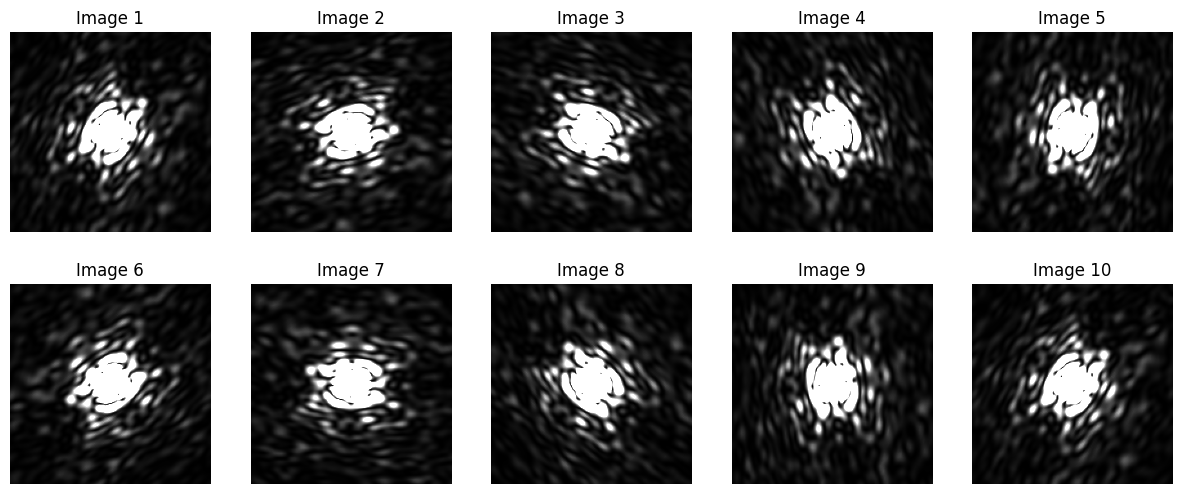

In [102]:
display_images(images, columns=5, vmax=3)